<a href="https://colab.research.google.com/github/nsambel1980/causal_discovery/blob/main/Surrogate_time_series_via_IAAFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Surrogate timeseries generation via IAAFT


[*********************100%***********************]  1 of 1 completed


Converged after 569 iterations.


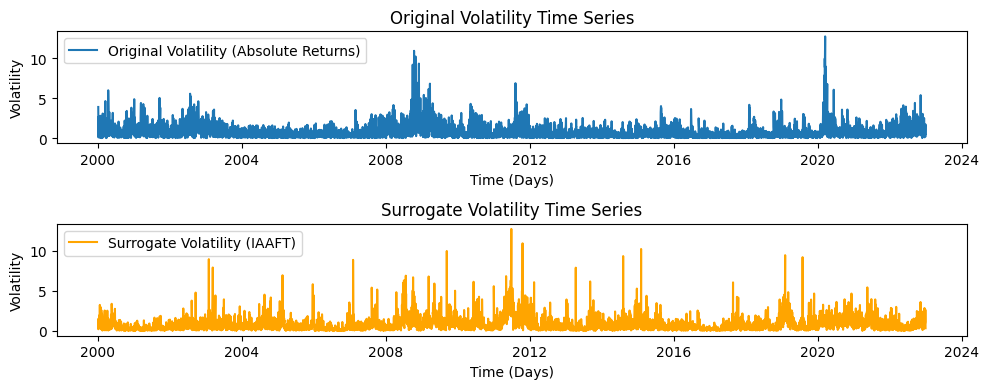

----------------------------------------------


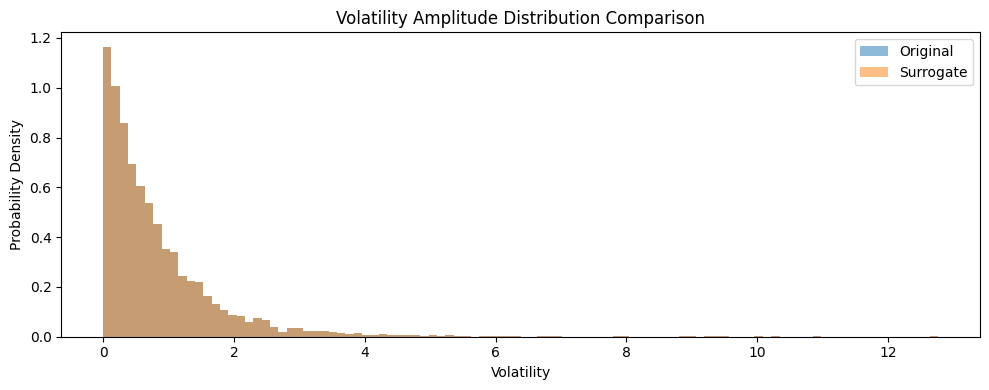

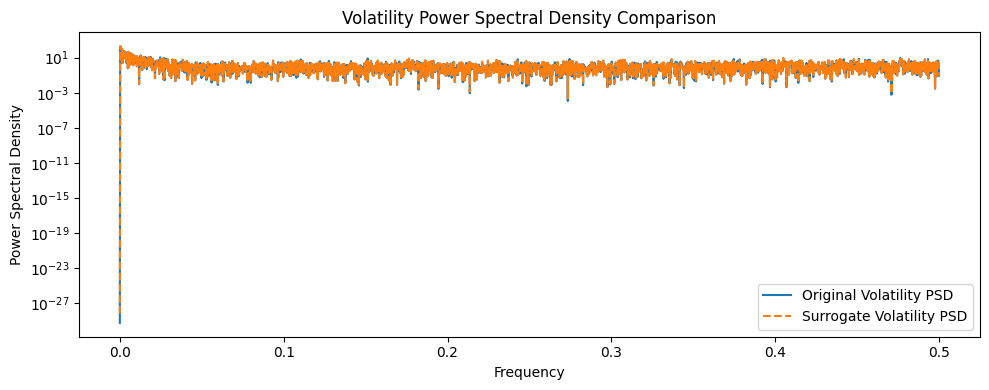

In [56]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
from scipy.signal import periodogram

# Define the IAAFT function
def iaaft(x, max_iter=1000, atol=1e-8):
    """
    Perform the Iterated Amplitude Adjusted Fourier Transform (IAAFT) algorithm
    to generate a surrogate time series that preserves the amplitude distribution
    and power spectrum of the original time series.

    Parameters:
    x : array_like
        Original time series data.
    max_iter : int, optional
        Maximum number of iterations for convergence. Default is 1000.
    atol : float, optional
        Absolute tolerance for convergence. Default is 1e-8.

    Returns:
    y : ndarray
        Surrogate time series.
    """
    n = len(x)
    # Sort the original time series
    x_sorted = np.sort(x)
    # Fourier transform of the original time series
    x_fft = fft(x)
    amplitude = np.abs(x_fft)
    # Initialize surrogate with a random shuffle
    y = np.random.permutation(x)
    # Initialize variables for convergence check
    prev_y = np.copy(y)
    for i in range(max_iter):
        # Fourier transform of the surrogate
        y_fft = fft(y)
        # Replace magnitude with that of the original time series
        y_fft = amplitude * np.exp(1j * np.angle(y_fft))
        # Inverse Fourier transform to get new surrogate
        y = np.real(ifft(y_fft))
        # Enforce the original amplitude distribution
        y = x_sorted[np.argsort(np.argsort(y))]
        # Check for convergence
        diff = np.linalg.norm(y - prev_y)
        if diff < atol:
            print(f"Converged after {i+1} iterations.")
            break
        prev_y = np.copy(y)
    else:
        print(f"Did not converge after {max_iter} iterations.")
    return y

# Step 1: Download SPX Index data
ticker_symbol = '^GSPC'  # S&P 500 Index ticker symbol in Yahoo Finance
spx_data = yf.download(ticker_symbol, start='2000-01-01', end='2023-01-01', interval='1d')
spx_data = spx_data.dropna()  # Drop any missing values

# Step 2: Compute logarithmic returns and volatility (absolute returns)
# Compute logarithmic prices
log_prices = np.log(spx_data['Close'])
# Compute logarithmic returns
returns = log_prices.diff().dropna().values
#t_returns = np.arange(len(returns))

# Compute volatility as absolute returns
volatility   = np.array([abs(el[0])*100. for el in returns])
t_volatility = np.array(log_prices.index[1:]) # align timestamp

# Step 3: Generate the surrogate volatility time series using IAAFT
np.random.seed(42)  # Set random seed for reproducibility
surrogate_volatility = iaaft(volatility, max_iter=1000, atol=1e-8)

# Step 4: Plot and compare the original and surrogate volatility time series
plt.figure(figsize=(10, 4))

# Original Volatility Series
plt.subplot(2, 1, 1)
plt.plot(t_volatility, volatility, label='Original Volatility (Absolute Returns)')
plt.title('Original Volatility Time Series')
plt.xlabel('Time (Days)')
plt.ylabel('Volatility')
plt.legend()

# Surrogate Volatility Series
plt.subplot(2, 1, 2)
plt.plot(t_volatility, surrogate_volatility, label='Surrogate Volatility (IAAFT)', color='orange')
plt.title('Surrogate Volatility Time Series')
plt.xlabel('Time (Days)')
plt.ylabel('Volatility')
plt.legend()
plt.tight_layout()
plt.show()
print("----------------------------------------------")
# Step 5: Compare amplitude distributions
plt.figure(figsize=(10, 4))
plt.hist(volatility,           bins=100, alpha=0.5, label='Original',  density=True)
plt.hist(surrogate_volatility, bins=100, alpha=0.5, label='Surrogate', density=True)
plt.title('Volatility Amplitude Distribution Comparison')
plt.xlabel('Volatility')
plt.ylabel('Probability Density')
plt.legend()
plt.tight_layout()
plt.show()

# Step 6: Compare power spectral densities
# Compute power spectral densities
freq_orig, psd_orig = periodogram(volatility)
freq_surr, psd_surr = periodogram(surrogate_volatility)

# Plot PSDs
plt.figure(figsize=(10, 4))
plt.semilogy(freq_orig, psd_orig, label='Original Volatility PSD')
plt.semilogy(freq_surr, psd_surr, label='Surrogate Volatility PSD', linestyle='--')
plt.title('Volatility Power Spectral Density Comparison')
plt.xlabel('Frequency')
plt.ylabel('Power Spectral Density')
plt.legend()
plt.tight_layout()
plt.show()